In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
# # Esatblishing connection with db
# conn = sqlite3.connect("database.sqlite")
# cur = conn.cursor()

# # Checking the values in 'Player Attribute' table
# cur.execute("""SELECT * FROM Player_Attributes LIMIT 3""")
# for row in cur:
#     print(row)

# # Checking the names of all tables in the db    
# cur.execute("""SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name""")
# for row in cur:
#     print(row)

# # Saving all column names on 'Player Attribut' table 
# table_col_names = []
# cur.execute("""PRAGMA table_info(Player_Attributes)""")
# for row in cur:
#     table_col_names.append(row[1])

# # Closing connection
# cur.close()
# conn.close()

In [4]:
# print(len(table_col_names))
# table_col_names

In [3]:
conn = sqlite3.connect('database.sqlite')
df_raw = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
conn.close()

In [4]:
df = df_raw.copy()

In [5]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [6]:
df.shape

(183978, 42)

In [7]:
# Backward Elimination

In [8]:
# df.info()

In [18]:
# df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1, inplace = True)

In [19]:
# df.dropna(inplace = True)
# print(df.shape)

In [20]:
cat_cols = df.select_dtypes(include = 'object')

In [21]:
cat_cols.nunique()

preferred_foot          2
attacking_work_rate     8
defensive_work_rate    18
dtype: int64

In [22]:
for i in cat_cols.columns:
    print(cat_cols[i].unique())

['right' 'left']
['medium' 'high' 'low' 'None' 'le' 'norm' 'stoc' 'y']
['medium' 'high' 'low' '5' 'ean' 'o' '1' 'ormal' '7' '2' '8' '4' 'tocky'
 '0' '3' '6' '9' 'es']


In [23]:
cat_cols['attacking_work_rate'].value_counts(normalize = True)

medium    0.693470
high      0.237439
low       0.047512
None      0.018392
norm      0.001758
y         0.000521
stoc      0.000477
le        0.000432
Name: attacking_work_rate, dtype: float64

In [24]:
# cat_cols['defensive_work_rate'].value_counts(normalize = True)

In [25]:
cat_cols.loc[~cat_cols['attacking_work_rate'].isin(['medium', 'high', 'low']), 'attacking_work_rate'] = 'other'

In [26]:
cat_cols.loc[~cat_cols['defensive_work_rate'].isin(['medium', 'high', 'low']), 'defensive_work_rate'] = 'other'

In [27]:
cat_cols = pd.get_dummies(cat_cols, columns = ['preferred_foot'])

In [28]:
ordinal_encode = {'other': 0, 'low': 1, 'medium': 2, 'high': 3}
cat_cols['attacking_work_rate'] = cat_cols['attacking_work_rate'].map(ordinal_encode)
cat_cols['defensive_work_rate'] = cat_cols['defensive_work_rate'].map(ordinal_encode)

In [29]:
# cat_cols

In [30]:
df.drop(["preferred_foot", "attacking_work_rate", "defensive_work_rate"], axis = 1, inplace = True)

In [31]:
df = pd.concat([df, cat_cols], axis = 1)

In [119]:
# df.info()

In [34]:
# Build model using sk
# Check important features using stats model?
# Multicolinearity?
# Check model assumptions from textbook
# Recursive feature elimination
# Cross validate
# L1 and L2 regression

In [35]:
df_50 = df.sample(n = 50000)

In [36]:
df_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 31326 to 126125
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   overall_rating        50000 non-null  float64
 1   potential             50000 non-null  float64
 2   crossing              50000 non-null  float64
 3   finishing             50000 non-null  float64
 4   heading_accuracy      50000 non-null  float64
 5   short_passing         50000 non-null  float64
 6   volleys               50000 non-null  float64
 7   dribbling             50000 non-null  float64
 8   curve                 50000 non-null  float64
 9   free_kick_accuracy    50000 non-null  float64
 10  long_passing          50000 non-null  float64
 11  ball_control          50000 non-null  float64
 12  acceleration          50000 non-null  float64
 13  sprint_speed          50000 non-null  float64
 14  agility               50000 non-null  float64
 15  reactions     

In [37]:
y = df_50['overall_rating']
X = df_50.drop('overall_rating', axis = 1)

In [38]:
col_name = X.columns

In [39]:
y_unscaled = y.copy()

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
y_scale = scaler.fit_transform(y.values.reshape((50000, 1)))

In [128]:
# Baseline Model
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size = 0.3)
lin_model1 = LinearRegression()
lin_model1.fit(X_train_base, y_train_base)
y_pred1 = lin_model1.predict(X_test_base)
rmse_base = math.sqrt(mean_squared_error(y_true = y_test_base, y_pred = y_pred1))
print(rmse_base)

2.803380876802796


In [41]:
import statsmodels.regression.linear_model as sm

In [95]:
stat_ols = sm.OLS(endog = y_scale, exog = X_scale).fit()
# stat_ols.summary()

In [46]:
# stat_ols.pvalues[stat_ols.pvalues>0.05]
np.argwhere(stat_ols.pvalues<=0.05).flatten()

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34],
      dtype=int64)

In [47]:
stat_ols.pvalues.shape

(38,)

In [48]:
np.argwhere(stat_ols.pvalues != np.max(stat_ols.pvalues)).flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36], dtype=int64)

In [49]:
def backward_elimination(X, y):
    significant_cols = np.array(range(38))
    p_val = [1]
    while len(p_val) > 0:
        stat_ols = sm.OLS(endog = y, exog = X[:, significant_cols]).fit()
        p_val = np.argwhere(stat_ols.pvalues>0.05).flatten()
        significant_cols = np.argwhere(stat_ols.pvalues != np.max(stat_ols.pvalues)).flatten()
    return significant_cols

In [52]:
features = backward_elimination(X_scale, y_scale)

In [53]:
len(features)

11

In [54]:
features = col_name[features]

In [55]:
X_ols = X.loc[:, features]
X_ols.head()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,acceleration
31326,77.0,50.0,38.0,76.0,54.0,38.0,47.0,40.0,29.0,48.0,67.0
126317,72.0,51.0,70.0,64.0,59.0,66.0,73.0,67.0,60.0,49.0,80.0
30207,70.0,18.0,15.0,13.0,30.0,18.0,23.0,17.0,16.0,28.0,43.0
3658,73.0,77.0,65.0,74.0,73.0,59.0,74.0,74.0,70.0,67.0,81.0
3189,67.0,73.0,59.0,57.0,70.0,72.0,70.0,73.0,67.0,70.0,65.0


In [56]:
# plt.figure(figsize = (15, 15))
# sns.heatmap(X.corr())

<Axes: >

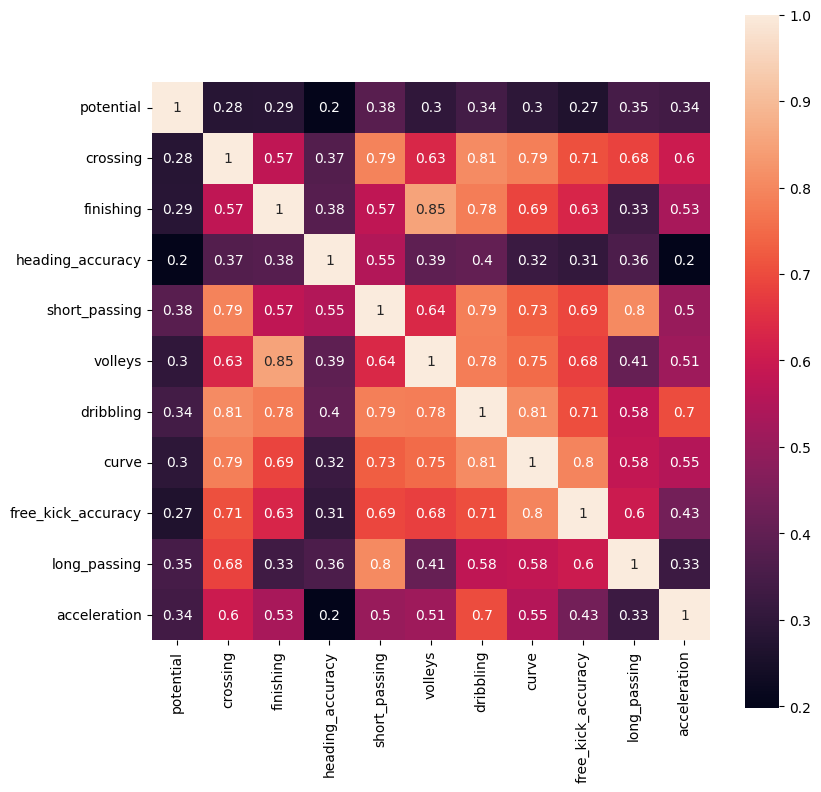

In [57]:
plt.figure(figsize = (9,9))
sns.heatmap(X_ols.corr(), annot = True, square = True)

In [63]:
X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(X_ols, y, test_size = 0.3)
lin_model2 = LinearRegression()
lin_model2.fit(X_train_ols, y_train_ols)
y_pred2 = lin_model2.predict(X_test_ols)
rmse_ols = math.sqrt(mean_squared_error(y_true = y_test_ols, y_pred = y_pred2))
print(rmse_ols)

4.131694988274411


In [77]:
# "overall_rating"
# out = df_50.reset_index(drop = True)
# out.to_csv('soccer_50.csv')

In [83]:
r_features = '''potential + crossing + finishing + heading_accuracy + short_passing + dribbling + curve + free_kick_accuracy + 
    long_passing + ball_control + acceleration + sprint_speed + 
    agility + reactions + balance + shot_power + jumping + stamina + 
    strength + long_shots + aggression + interceptions + positioning + 
    penalties + marking + sliding_tackle + gk_diving + gk_handling + 
    gk_kicking + gk_positioning + gk_reflexes + attacking_work_rate
    '''

#### Features obtained from backward elimination process done in R, using AIC metric
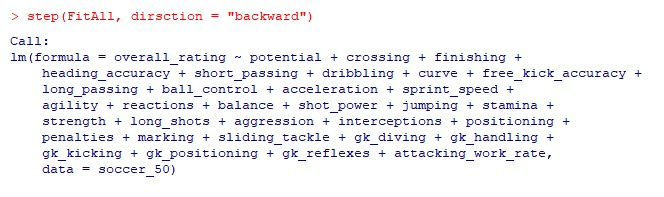

In [88]:
# r_features = [i for i in r_features.split() if i != "+"]
print(r_features)
len(r_features)

['potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'penalties', 'marking', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'attacking_work_rate']


32

In [93]:
X_r = X.loc[:, r_features]

In [94]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y, test_size = 0.3)
lin_model3 = LinearRegression()
lin_model3.fit(X_train_r, y_train_r)
y_pred3 = lin_model3.predict(X_test_r)
rmse_r = math.sqrt(mean_squared_error(y_true = y_test_r, y_pred = y_pred3))
print(rmse_r)

2.8049758995215486


In [97]:
# RMSE of training data
y_pred4 = lin_model3.predict(X_train_r)
rmse_r_train = math.sqrt(mean_squared_error(y_true = y_train_r, y_pred = y_pred4))
print(rmse_r_train)

2.787938298119211


In [99]:
# Checking residuals
e1_train = y_pred4 - y_train_r
e1_test = y_pred3 - y_test_r

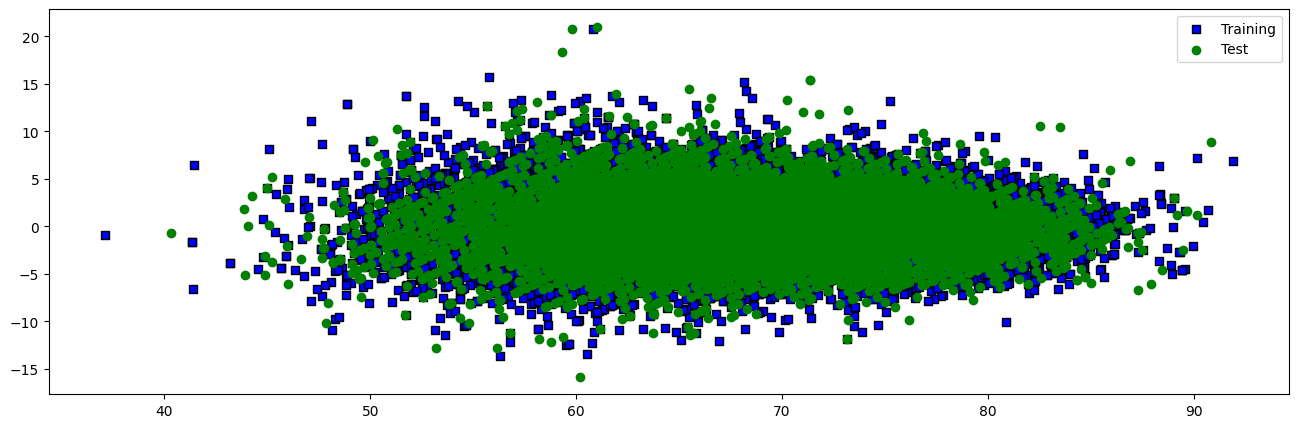

In [116]:
plt.figure(figsize = (16, 5))
plt.scatter(x = y_pred4, y = e1_train, c = 'blue', marker = 's', label = 'Training', edgecolors = 'black')
plt.scatter(x = y_pred3, y = e1_test, c = 'green', label = 'Test')
plt.legend()

In [182]:
# L1 and L2 regularization
from sklearn.linear_model import RidgeCV, LassoCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

lin_ridge = RidgeCV(alphas = [2200, 2300, 2400, 2500, 2600], cv = 10)
lin_ridge.fit(X_train, y_train)
print("Best alpha", lin_ridge.alpha_)

y_pred5_train = lin_ridge.predict(X_train)
y_pred5_test = lin_ridge.predict(X_test)

rmse_ridge_train = math.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred5_train))
print(rmse_ridge_train)
rmse_ridge_test = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred5_test))
print(rmse_ridge_test)

Best alpha 2200
2.798928587925639
2.7796445659800244


<BarContainer object of 38 artists>

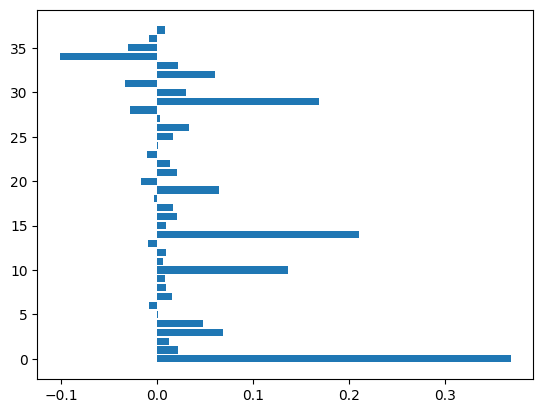

In [183]:
plt.barh(y = pd.Series(lin_ridge.coef_).index, width = lin_ridge.coef_, align = 'center')

In [180]:
lin_lasso = lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], max_iter = 50000, cv = 10)
lin_lasso.fit(X_train, y_train)
print("Best alpha", lin_lasso.alpha_)

y_pred6_train = lin_lasso.predict(X_train)
y_pred6_test = lin_lasso.predict(X_test)

rmse_lasso_train = math.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred6_train))
print(rmse_lasso_train)
rmse_lasso_test = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred6_test))
print(rmse_lasso_test)

Best alpha 0.006
2.78469516673376
2.8126319836527878


<BarContainer object of 38 artists>

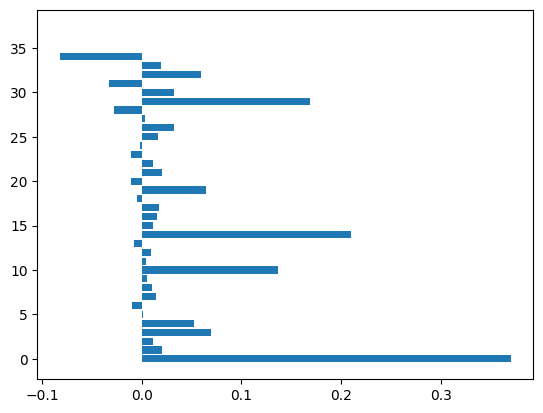

In [181]:
plt.barh(y = pd.Series(lin_lasso.coef_).index, width = lin_lasso.coef_, align = 'center')

In [156]:
# e1_train = y_train - y_pred5_train
# e1_test = y_test - y_pred5_test
# plt.figure(figsize = (16, 5))
# plt.scatter(x = y_pred5_train, y = e1_train, c = 'blue', marker = 's', label = 'Training', edgecolors = 'black')
# plt.scatter(x = y_pred5_test, y = e1_test, c = 'green', label = 'Test')
# plt.legend()

In [36]:
# Manually selecting features (34)
features = ['potential', 'crossing', 'finishing', 'heading_accuracy',
           'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
           'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
           'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
           'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
           'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
           'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
           'gk_reflexes']
target = ['overall_rating']

In [38]:
# df_50.info()

In [40]:
df_50 = df_50.dropna()
df_50.shape

(49012, 42)

In [41]:
X = df_50[features]
y = df_50[target]

In [45]:
X.head()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
92296,69.0,64.0,62.0,43.0,62.0,49.0,68.0,69.0,68.0,60.0,...,63.0,61.0,16.0,27.0,29.0,13.0,8.0,6.0,7.0,6.0
50343,83.0,50.0,44.0,57.0,73.0,50.0,72.0,49.0,57.0,66.0,...,67.0,59.0,54.0,59.0,47.0,13.0,7.0,7.0,12.0,10.0
107417,64.0,58.0,45.0,52.0,55.0,52.0,63.0,47.0,56.0,54.0,...,54.0,41.0,36.0,42.0,28.0,10.0,6.0,11.0,12.0,9.0
118031,72.0,47.0,75.0,77.0,66.0,70.0,62.0,49.0,39.0,41.0,...,68.0,68.0,22.0,29.0,17.0,3.0,3.0,3.0,3.0,3.0
89882,72.0,31.0,33.0,68.0,52.0,32.0,41.0,29.0,30.0,47.0,...,35.0,39.0,68.0,69.0,68.0,15.0,10.0,10.0,12.0,15.0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [49]:
lin_model1 = LinearRegression()
lin_model1.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred1 = lin_model1.predict(X_test)
y_pred1

array([[79.01520896],
       [78.22603517],
       [74.33510149],
       ...,
       [69.87301914],
       [68.27069969],
       [66.37610715]])

In [52]:
y_pred1.mean()

68.597019183854

In [53]:
df['overall_rating'].mean()

68.6000152886831

In [80]:
# Root Mean Squared Error
rmse_lin = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred1))
print(rmse_lin)

2.7886874646658746


In [77]:
rf1 = RandomForestRegressor()
rf1.fit(X_train, y_train.values.flatten())

RandomForestRegressor()

In [78]:
y_pred2 = rf1.predict(X_test)
y_pred2

array([78.6       , 77.81      , 74.78      , ..., 72.83416667,
       69.305     , 63.906     ])

In [79]:
y_pred2.mean()

68.60118758957422

In [81]:
rmse_rf = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred2))
print(rmse_rf)

1.3415178752503538
